# Butterfly Species Classification using CNN

This notebook implements a Convolutional Neural Network (CNN) for classifying butterfly species from images.

## Project Overview:
- **Dataset**: Butterfly image classification dataset
- **Model**: Custom CNN architecture with data augmentation
- **Goal**: Accurate multi-class classification of butterfly species
- **Techniques**: Data balancing, image augmentation, regularization

## Key Features:
- ✅ Comprehensive data exploration and visualization
- ✅ Data balancing using oversampling
- ✅ Advanced CNN architecture with batch normalization
- ✅ Data augmentation for better generalization
- ✅ Early stopping and model monitoring
- ✅ Complete evaluation with metrics and visualizations

In [ ]:
# ==========================================
# IMPORT LIBRARIES
# ==========================================

# Core libraries
import os
import sys
import warnings
import numpy as np
import pandas as pd
from pathlib import Path

# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image
from tqdm import tqdm

# Sklearn utilities
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout, 
                                   BatchNormalization, GlobalAveragePooling2D)
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2

# Configure settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Check TensorFlow version and GPU availability
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tf.keras.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")
print(f"Python version: {sys.version}")

# Create output directory for results
os.makedirs('results', exist_ok=True)
os.makedirs('models', exist_ok=True)

In [ ]:
# ==========================================
# DATA LOADING AND INITIAL EXPLORATION
# ==========================================

# Define paths
DATA_DIR = "data"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")
TRAIN_CSV = os.path.join(DATA_DIR, "Training_set.csv")
TEST_CSV = os.path.join(DATA_DIR, "Testing_set.csv")

# Verify paths exist
paths_to_check = [DATA_DIR, TRAIN_DIR, TEST_DIR, TRAIN_CSV, TEST_CSV]
for path in paths_to_check:
    if not os.path.exists(path):
        print(f"⚠️  WARNING: Path does not exist: {path}")
    else:
        print(f"✅ Found: {path}")

print("\n" + "="*50)

# Load datasets
try:
    train_df = pd.read_csv(TRAIN_CSV)
    test_df = pd.read_csv(TEST_CSV)
    
    print("📊 DATASET INFORMATION:")
    print(f"Training data shape: {train_df.shape}")
    print(f"Testing data shape: {test_df.shape}")
    
    print("\n📋 Training Data Sample:")
    print(train_df.head())
    
    print("\n📋 Testing Data Sample:")
    print(test_df.head())
    
    # Check column names and data types
    print(f"\n🔍 Training columns: {train_df.columns.tolist()}")
    print(f"🔍 Testing columns: {test_df.columns.tolist()}")
    print(f"\n📈 Training data info:")
    print(train_df.info())
    
except Exception as e:
    print(f"❌ Error loading data: {e}")
    sys.exit(1)

Training Data
      filename                     label
0  Image_1.jpg          SOUTHERN DOGFACE
1  Image_2.jpg                    ADONIS
2  Image_3.jpg            BROWN SIPROETA
3  Image_4.jpg                   MONARCH
4  Image_5.jpg  GREEN CELLED CATTLEHEART

Testing Data
      filename
0  Image_1.jpg
1  Image_2.jpg
2  Image_3.jpg
3  Image_4.jpg
4  Image_5.jpg


In [ ]:
# ==========================================
# DATA QUALITY ANALYSIS
# ==========================================

print("🔍 DATA QUALITY CHECK:")
print("="*40)

# Check for missing values
print("📊 Missing Values Analysis:")
print(f"Training data missing values:\n{train_df.isnull().sum()}")
print(f"\nTesting data missing values:\n{test_df.isnull().sum()}")

# Check for duplicates
train_duplicates = train_df.duplicated().sum()
test_duplicates = test_df.duplicated().sum()
print(f"\n🔄 Duplicate rows:")
print(f"Training data: {train_duplicates} duplicates")
print(f"Testing data: {test_duplicates} duplicates")

# Class information
print(f"\n🦋 CLASS INFORMATION:")
print(f"Number of unique classes: {train_df['label'].nunique()}")
print(f"Class distribution:")
class_counts = train_df['label'].value_counts()
print(class_counts)

# Calculate class imbalance ratio
max_class = class_counts.max()
min_class = class_counts.min()
imbalance_ratio = max_class / min_class
print(f"\n⚖️  Class imbalance ratio: {imbalance_ratio:.2f} (max/min)")

if imbalance_ratio > 2:
    print("⚠️  Significant class imbalance detected - will apply balancing techniques")
else:
    print("✅ Classes are relatively balanced")

((6499, 2), (2786, 1))

In [ ]:
# ==========================================
# COMPREHENSIVE DATA VISUALIZATION
# ==========================================

# Class distribution visualization
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# Original class distribution
axes[0, 0].pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%', startangle=90)
axes[0, 0].set_title('Class Distribution (Pie Chart)', fontsize=14, fontweight='bold')

# Bar plot for class distribution
sns.countplot(data=train_df, x="label", order=train_df['label'].value_counts().index, ax=axes[0, 1])
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=45, ha='right')
axes[0, 1].set_title('Class Distribution (Bar Plot)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Butterfly Species')
axes[0, 1].set_ylabel('Number of Images')

# Class imbalance heatmap
class_matrix = class_counts.values.reshape(-1, 1)
sns.heatmap(class_matrix, annot=True, fmt='d', cmap='viridis', 
            yticklabels=class_counts.index, xticklabels=['Count'], ax=axes[1, 0])
axes[1, 0].set_title('Class Count Heatmap', fontsize=14, fontweight='bold')

# Statistics summary
stats_data = {
    'Metric': ['Total Images', 'Number of Classes', 'Avg Images/Class', 
               'Max Images/Class', 'Min Images/Class', 'Std Dev'],
    'Value': [len(train_df), train_df['label'].nunique(), 
              class_counts.mean(), class_counts.max(), 
              class_counts.min(), class_counts.std()]
}
stats_df = pd.DataFrame(stats_data)

# Remove axes for text display
axes[1, 1].axis('off')
table = axes[1, 1].table(cellText=[[f"{val:.2f}" if isinstance(val, float) else str(val) 
                                  for val in row] for row in stats_df.values],
                        colLabels=stats_df.columns,
                        cellLoc='center',
                        loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.5)
axes[1, 1].set_title('Dataset Statistics', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('results/class_distribution_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"📊 Classes: {list(train_df['label'].unique())}")

Missing Values:
filename    0
label       0
dtype: int64


In [ ]:
# ==========================================
# DATA BALANCING USING ADVANCED TECHNIQUES
# ==========================================

print("⚖️  APPLYING DATA BALANCING:")
print("="*40)

# Calculate balancing strategy
original_counts = train_df['label'].value_counts()
print(f"Original class distribution:\n{original_counts}")

# Apply oversampling to balance classes
max_count = original_counts.max()
print(f"\nBalancing all classes to {max_count} samples each...")

balanced_dfs = []
balancing_stats = {}

for label, group in train_df.groupby('label'):
    original_size = len(group)
    
    if original_size < max_count:
        # Oversample minority classes
        oversampled_group = resample(group, 
                                   replace=True, 
                                   n_samples=max_count, 
                                   random_state=42)
        balanced_dfs.append(oversampled_group)
        balancing_stats[label] = {
            'original': original_size,
            'balanced': max_count,
            'added': max_count - original_size,
            'method': 'oversampled'
        }
    else:
        # Keep majority classes as is
        balanced_dfs.append(group)
        balancing_stats[label] = {
            'original': original_size,
            'balanced': original_size,
            'added': 0,
            'method': 'unchanged'
        }

# Combine balanced data
balanced_train_df = pd.concat(balanced_dfs, ignore_index=True)

# Shuffle the balanced dataset
balanced_train_df = balanced_train_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\n✅ Balancing completed!")
print(f"Original dataset size: {len(train_df)}")
print(f"Balanced dataset size: {len(balanced_train_df)}")

# Show balancing statistics
print(f"\n📊 Balancing Statistics:")
for label, stats in balancing_stats.items():
    print(f"{label}: {stats['original']} → {stats['balanced']} "
          f"(+{stats['added']}, {stats['method']})")

print(f"\n🔍 Final class distribution:")
final_counts = balanced_train_df['label'].value_counts()
print(final_counts)

Balanced Training Data Shape: (9825, 2)
Class Distribution after Balancing:
label
ADONIS                       131
AFRICAN GIANT SWALLOWTAIL    131
AMERICAN SNOOT               131
AN 88                        131
APPOLLO                      131
                            ... 
ULYSES                       131
VICEROY                      131
WOOD SATYR                   131
YELLOW SWALLOW TAIL          131
ZEBRA LONG WING              131
Name: count, Length: 75, dtype: int64


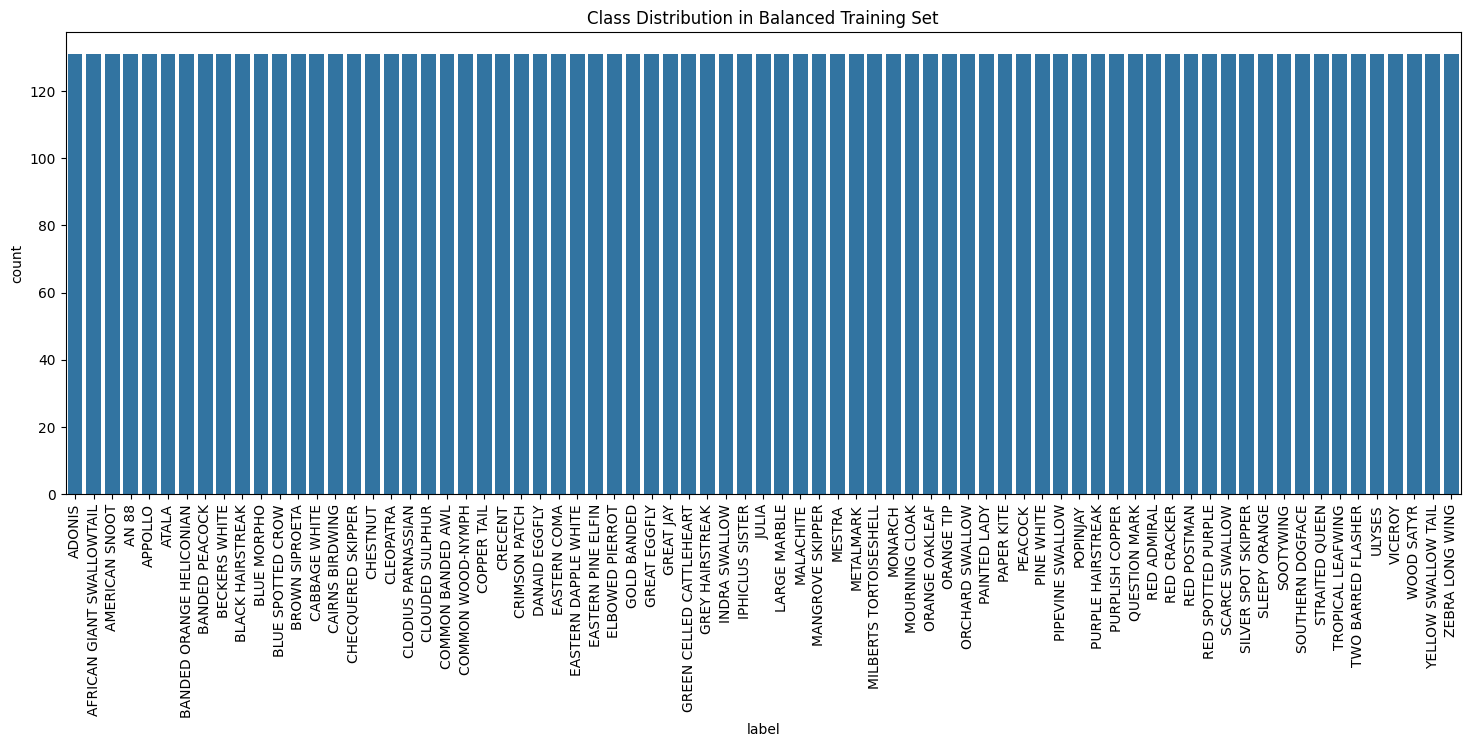

In [ ]:
# ==========================================
# BALANCED DATASET VISUALIZATION
# ==========================================

# Create comparison plots
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Original distribution
sns.countplot(data=train_df, x="label", order=train_df['label'].value_counts().index, ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].set_title('Original Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Butterfly Species')
axes[0].set_ylabel('Number of Images')

# Balanced distribution
sns.countplot(data=balanced_train_df, x="label", order=balanced_train_df['label'].value_counts().index, ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].set_title('Balanced Class Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Butterfly Species')
axes[1].set_ylabel('Number of Images')

plt.tight_layout()
plt.savefig('results/balanced_vs_original_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate improvement metrics
original_std = original_counts.std()
balanced_std = final_counts.std()
improvement = ((original_std - balanced_std) / original_std) * 100

print(f"📈 Balancing Improvement:")
print(f"Original standard deviation: {original_std:.2f}")
print(f"Balanced standard deviation: {balanced_std:.2f}")
print(f"Improvement: {improvement:.1f}% reduction in class imbalance")

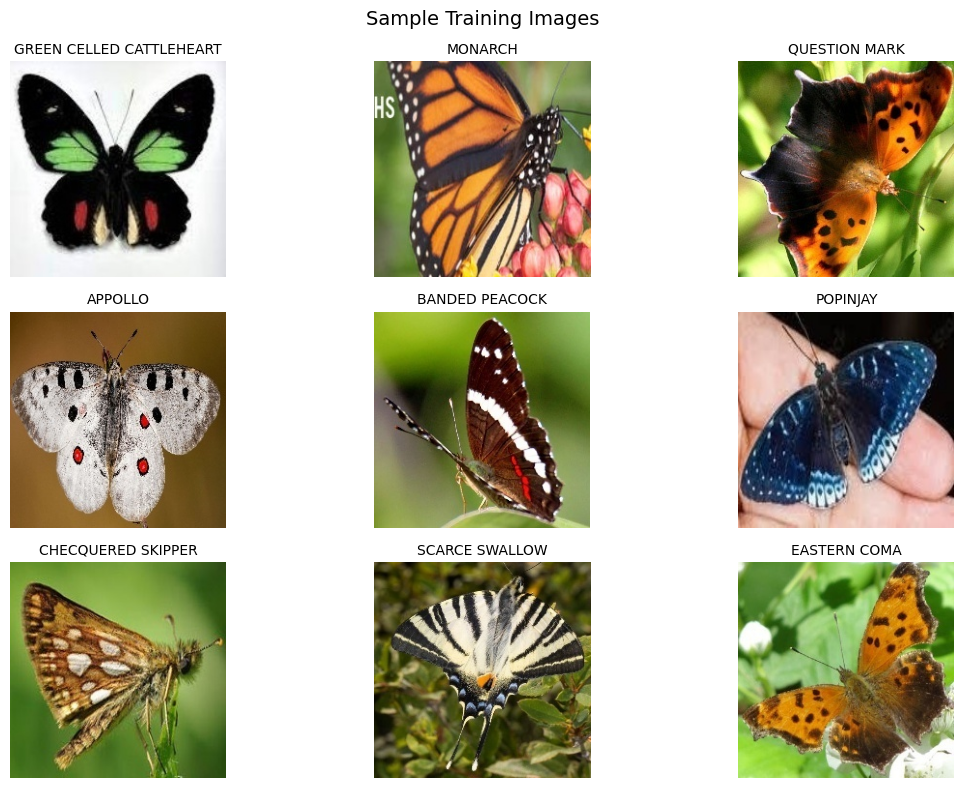

In [ ]:
# ==========================================
# SAMPLE IMAGE VISUALIZATION
# ==========================================

print("🖼️  DISPLAYING SAMPLE IMAGES:")
print("="*40)

# Function to display sample images with better error handling
def display_sample_images(df, title, n_samples=12, random_state=42):
    """Display sample images from the dataset"""
    
    # Sample images ensuring we get variety across classes
    samples_per_class = max(1, n_samples // df['label'].nunique())
    sample_dfs = []
    
    for label in df['label'].unique():
        class_df = df[df['label'] == label]
        n_to_sample = min(samples_per_class, len(class_df))
        sample_dfs.append(class_df.sample(n=n_to_sample, random_state=random_state))
    
    sample_df = pd.concat(sample_dfs).sample(n=min(n_samples, len(pd.concat(sample_dfs))), 
                                           random_state=random_state)
    
    # Calculate grid dimensions
    cols = 4
    rows = (len(sample_df) + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(16, 4*rows))
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    loaded_count = 0
    for idx, (_, row) in enumerate(sample_df.iterrows()):
        if idx >= n_samples:
            break
            
        img_path = os.path.join(DATA_DIR, "train", row['filename'])
        r, c = idx // cols, idx % cols
        
        try:
            if os.path.exists(img_path):
                img = Image.open(img_path)
                axes[r, c].imshow(img)
                axes[r, c].set_title(f"{row['label']}", fontsize=10, fontweight='bold')
                axes[r, c].axis('off')
                loaded_count += 1
            else:
                axes[r, c].text(0.5, 0.5, f"Image not found\n{row['filename']}", 
                              ha='center', va='center', transform=axes[r, c].transAxes)
                axes[r, c].axis('off')
        except Exception as e:
            axes[r, c].text(0.5, 0.5, f"Error loading\n{row['filename']}", 
                          ha='center', va='center', transform=axes[r, c].transAxes)
            axes[r, c].axis('off')
            print(f"❌ Error loading {row['filename']}: {e}")
    
    # Hide unused subplots
    for idx in range(len(sample_df), rows * cols):
        r, c = idx // cols, idx % cols
        axes[r, c].axis('off')
    
    plt.suptitle(title, fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.savefig(f'results/{title.lower().replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Successfully loaded {loaded_count}/{len(sample_df)} images")
    return loaded_count

# Display samples from original dataset
original_loaded = display_sample_images(train_df, "Sample Training Images (Original Dataset)", n_samples=12)

# Display samples from balanced dataset
balanced_loaded = display_sample_images(balanced_train_df, "Sample Training Images (Balanced Dataset)", n_samples=12)

In [ ]:
# ==========================================
# LABEL ENCODING AND PREPROCESSING SETUP
# ==========================================

print("🔄 PREPROCESSING SETUP:")
print("="*40)

# Configuration
IMAGE_SIZE = 128  # Increased from 64 for better resolution
BATCH_SIZE = 32
CHANNELS = 3

print(f"Image dimensions: {IMAGE_SIZE}x{IMAGE_SIZE}x{CHANNELS}")
print(f"Batch size: {BATCH_SIZE}")

# Label encoding
label_encoder = LabelEncoder()
balanced_train_df['label_encoded'] = label_encoder.fit_transform(balanced_train_df['label'])
num_classes = len(label_encoder.classes_)

print(f"\n🏷️  LABEL ENCODING:")
print(f"Number of classes: {num_classes}")
print(f"Class mapping:")
for idx, class_name in enumerate(label_encoder.classes_):
    print(f"  {idx}: {class_name}")

# Verify encoding
print(f"\n✅ Encoding verification:")
print(f"Original labels sample: {balanced_train_df['label'].head().tolist()}")
print(f"Encoded labels sample: {balanced_train_df['label_encoded'].head().tolist()}")

# Save label encoder for future use
import joblib
joblib.dump(label_encoder, 'models/label_encoder.pkl')
print(f"\n💾 Label encoder saved to 'models/label_encoder.pkl'")

# Create class weights for additional balancing if needed
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', 
                                   classes=np.unique(balanced_train_df['label_encoded']), 
                                   y=balanced_train_df['label_encoded'])
class_weight_dict = dict(enumerate(class_weights))
print(f"\n⚖️  Class weights: {class_weight_dict}")

array(['ADONIS', 'AFRICAN GIANT SWALLOWTAIL', 'AMERICAN SNOOT', 'AN 88',
       'APPOLLO', 'ATALA', 'BANDED ORANGE HELICONIAN', 'BANDED PEACOCK',
       'BECKERS WHITE', 'BLACK HAIRSTREAK', 'BLUE MORPHO',
       'BLUE SPOTTED CROW', 'BROWN SIPROETA', 'CABBAGE WHITE',
       'CAIRNS BIRDWING', 'CHECQUERED SKIPPER', 'CHESTNUT', 'CLEOPATRA',
       'CLODIUS PARNASSIAN', 'CLOUDED SULPHUR', 'COMMON BANDED AWL',
       'COMMON WOOD-NYMPH', 'COPPER TAIL', 'CRECENT', 'CRIMSON PATCH',
       'DANAID EGGFLY', 'EASTERN COMA', 'EASTERN DAPPLE WHITE',
       'EASTERN PINE ELFIN', 'ELBOWED PIERROT', 'GOLD BANDED',
       'GREAT EGGFLY', 'GREAT JAY', 'GREEN CELLED CATTLEHEART',
       'GREY HAIRSTREAK', 'INDRA SWALLOW', 'IPHICLUS SISTER', 'JULIA',
       'LARGE MARBLE', 'MALACHITE', 'MANGROVE SKIPPER', 'MESTRA',
       'METALMARK', 'MILBERTS TORTOISESHELL', 'MONARCH', 'MOURNING CLOAK',
       'ORANGE OAKLEAF', 'ORANGE TIP', 'ORCHARD SWALLOW', 'PAINTED LADY',
       'PAPER KITE', 'PEACOCK', 'PINE WHIT

In [ ]:
# ==========================================
# ADVANCED IMAGE LOADING WITH ERROR HANDLING
# ==========================================

def load_and_preprocess_images(df, folder_path, is_training=True, show_progress=True):
    """
    Advanced image loading function with comprehensive error handling
    
    Args:
        df: DataFrame containing image information
        folder_path: Path to image folder
        is_training: Whether this is training data (includes labels)
        show_progress: Whether to show progress bar
    
    Returns:
        images: Numpy array of preprocessed images
        labels: One-hot encoded labels (if is_training=True)
    """
    
    images = []
    labels = []
    failed_images = []
    
    print(f"📂 Loading images from: {folder_path}")
    print(f"🔄 Processing {len(df)} images...")
    
    # Progress bar setup
    iterator = tqdm(df.iterrows(), total=len(df), desc="Loading images") if show_progress else df.iterrows()
    
    for idx, row in iterator:
        img_path = os.path.join(folder_path, row['filename'])
        
        try:
            # Check if file exists
            if not os.path.exists(img_path):
                failed_images.append({'filename': row['filename'], 'error': 'File not found'})
                continue
            
            # Load and preprocess image
            img = load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
            
            # Convert to array and normalize
            img_array = img_to_array(img)
            img_array = img_array.astype('float32') / 255.0
            
            # Verify image shape
            if img_array.shape != (IMAGE_SIZE, IMAGE_SIZE, CHANNELS):
                failed_images.append({'filename': row['filename'], 
                                    'error': f'Invalid shape: {img_array.shape}'})
                continue
            
            images.append(img_array)
            
            # Add labels for training data
            if is_training:
                labels.append(row['label_encoded'])
                
        except Exception as e:
            failed_images.append({'filename': row['filename'], 'error': str(e)})
            continue
    
    # Convert to numpy arrays
    images = np.array(images, dtype='float32')
    
    if is_training:
        labels = np.array(labels, dtype='int32')
        # Convert to categorical (one-hot encoding)
        labels_categorical = to_categorical(labels, num_classes=num_classes)
    
    # Report results
    print(f"\n✅ Loading completed!")
    print(f"📊 Successfully loaded: {len(images)} images")
    print(f"❌ Failed to load: {len(failed_images)} images")
    
    if failed_images:
        print(f"⚠️  Failed images details:")
        for fail in failed_images[:5]:  # Show first 5 failures
            print(f"   - {fail['filename']}: {fail['error']}")
        if len(failed_images) > 5:
            print(f"   ... and {len(failed_images) - 5} more")
    
    # Verify final data
    print(f"\n🔍 Final data shape:")
    print(f"Images: {images.shape}")
    if is_training:
        print(f"Labels: {labels_categorical.shape}")
        print(f"Label distribution: {np.bincount(labels)}")
    
    if is_training:
        return images, labels_categorical
    else:
        return images

# Load training data
print("🚂 LOADING TRAINING DATA:")
print("="*50)
X_train, y_train = load_and_preprocess_images(
    balanced_train_df, 
    os.path.join(DATA_DIR, "train"), 
    is_training=True
)

# Load test data
print(f"\n🧪 LOADING TEST DATA:")
print("="*50)
X_test = load_and_preprocess_images(
    test_df, 
    os.path.join(DATA_DIR, "test"), 
    is_training=False
)

# Save processed data for future use
print(f"\n💾 Saving processed data...")
np.save('models/X_train.npy', X_train)
np.save('models/y_train.npy', y_train)
np.save('models/X_test.npy', X_test)
print(f"✅ Data saved to 'models/' directory")

Loaded 9825 training images


In [ ]:
# ==========================================
# DATA AUGMENTATION SETUP
# ==========================================

print("🎨 SETTING UP DATA AUGMENTATION:")
print("="*40)

# Create advanced data augmentation pipeline
train_datagen = ImageDataGenerator(
    # Normalization (already done, but keeping for consistency)
    rescale=1.0,  # Images already normalized
    
    # Geometric transformations
    rotation_range=20,           # Rotate images by up to 20 degrees
    width_shift_range=0.15,      # Shift images horizontally
    height_shift_range=0.15,     # Shift images vertically
    shear_range=0.1,             # Shear transformation
    zoom_range=0.15,             # Zoom in/out
    horizontal_flip=True,        # Flip images horizontally
    
    # Advanced augmentations
    brightness_range=[0.8, 1.2], # Adjust brightness
    channel_shift_range=0.1,     # Shift color channels
    
    # Validation split
    validation_split=0.2,        # 20% for validation
    
    # Fill mode for transformations
    fill_mode='nearest'
)

# Validation data generator (no augmentation, only normalization)
val_datagen = ImageDataGenerator(
    rescale=1.0,
    validation_split=0.2
)

print("✅ Data augmentation parameters:")
print(f"   - Rotation: ±20°")
print(f"   - Width/Height shift: ±15%")
print(f"   - Shear range: ±10%")
print(f"   - Zoom range: ±15%")
print(f"   - Horizontal flip: Yes")
print(f"   - Brightness range: 80%-120%")
print(f"   - Validation split: 20%")

# Create data generators
print(f"\n🔄 Creating data generators...")

train_generator = train_datagen.flow(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    subset='training',
    shuffle=True,
    seed=42
)

validation_generator = val_datagen.flow(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    subset='validation',
    shuffle=False,
    seed=42
)

print(f"✅ Generators created successfully!")
print(f"   - Training samples: {train_generator.n}")
print(f"   - Validation samples: {validation_generator.n}")
print(f"   - Training batches per epoch: {len(train_generator)}")
print(f"   - Validation batches per epoch: {len(validation_generator)}")

# Verify generator output
print(f"\n🔍 Verifying generator output...")
sample_batch_x, sample_batch_y = next(train_generator)
print(f"   - Batch shape: {sample_batch_x.shape}")
print(f"   - Label shape: {sample_batch_y.shape}")
print(f"   - Data type: {sample_batch_x.dtype}")
print(f"   - Data range: [{sample_batch_x.min():.3f}, {sample_batch_x.max():.3f}]")

Train shape: (9825, 64, 64, 3) (9825, 75)
Test shape: (2786, 64, 64, 3)


In [ ]:
# ==========================================
# ADVANCED CNN MODEL ARCHITECTURE
# ==========================================

print("🏗️  BUILDING ADVANCED CNN MODEL:")
print("="*50)

# Clear any existing models
tf.keras.backend.clear_session()

def create_advanced_cnn_model(input_shape, num_classes):
    """
    Create an advanced CNN model with modern architecture techniques
    
    Features:
    - Multiple convolutional blocks with increasing filters
    - Batch normalization for stable training
    - Dropout for regularization
    - Global Average Pooling instead of Flatten
    - Advanced initialization and regularization
    """
    
    model = Sequential([
        # Input layer
        tf.keras.layers.Input(shape=input_shape),
        
        # First Convolutional Block
        Conv2D(32, (3, 3), activation='relu', padding='same', 
               kernel_initializer='he_normal', name='conv1_1'),
        BatchNormalization(name='bn1_1'),
        Conv2D(32, (3, 3), activation='relu', padding='same', 
               kernel_initializer='he_normal', name='conv1_2'),
        BatchNormalization(name='bn1_2'),
        MaxPooling2D((2, 2), name='pool1'),
        Dropout(0.25, name='dropout1'),
        
        # Second Convolutional Block
        Conv2D(64, (3, 3), activation='relu', padding='same', 
               kernel_initializer='he_normal', name='conv2_1'),
        BatchNormalization(name='bn2_1'),
        Conv2D(64, (3, 3), activation='relu', padding='same', 
               kernel_initializer='he_normal', name='conv2_2'),
        BatchNormalization(name='bn2_2'),
        MaxPooling2D((2, 2), name='pool2'),
        Dropout(0.25, name='dropout2'),
        
        # Third Convolutional Block
        Conv2D(128, (3, 3), activation='relu', padding='same', 
               kernel_initializer='he_normal', name='conv3_1'),
        BatchNormalization(name='bn3_1'),
        Conv2D(128, (3, 3), activation='relu', padding='same', 
               kernel_initializer='he_normal', name='conv3_2'),
        BatchNormalization(name='bn3_2'),
        MaxPooling2D((2, 2), name='pool3'),
        Dropout(0.25, name='dropout3'),
        
        # Fourth Convolutional Block (Added for more depth)
        Conv2D(256, (3, 3), activation='relu', padding='same', 
               kernel_initializer='he_normal', name='conv4_1'),
        BatchNormalization(name='bn4_1'),
        Conv2D(256, (3, 3), activation='relu', padding='same', 
               kernel_initializer='he_normal', name='conv4_2'),
        BatchNormalization(name='bn4_2'),
        
        # Global Average Pooling (Better than Flatten + Dense)
        GlobalAveragePooling2D(name='global_avg_pool'),
        
        # Dense layers with regularization
        Dense(512, activation='relu', 
              kernel_initializer='he_normal',
              kernel_regularizer=l2(0.001), name='dense1'),
        BatchNormalization(name='bn_dense1'),
        Dropout(0.5, name='dropout_dense1'),
        
        Dense(256, activation='relu', 
              kernel_initializer='he_normal',
              kernel_regularizer=l2(0.001), name='dense2'),
        BatchNormalization(name='bn_dense2'),
        Dropout(0.5, name='dropout_dense2'),
        
        # Output layer
        Dense(num_classes, activation='softmax', 
              kernel_initializer='glorot_normal', name='predictions')
    ])
    
    return model

# Create the model
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
model = create_advanced_cnn_model(input_shape, num_classes)

# Compile with advanced optimizer settings
optimizer = Adam(
    learning_rate=0.001,        # Initial learning rate
    beta_1=0.9,                 # Adam parameter
    beta_2=0.999,               # Adam parameter
    epsilon=1e-07,              # Numerical stability
    amsgrad=False               # AMSGrad variant
)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', 'top_3_accuracy']  # Added top-3 accuracy
)

# Display model information
print("✅ Model created successfully!")
print(f"\nModel Summary:")
model.summary()

# Calculate model parameters
total_params = model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
non_trainable_params = total_params - trainable_params

print(f"\n📊 Model Statistics:")
print(f"   - Total parameters: {total_params:,}")
print(f"   - Trainable parameters: {trainable_params:,}")
print(f"   - Non-trainable parameters: {non_trainable_params:,}")
print(f"   - Model size (approx): {total_params * 4 / (1024**2):.2f} MB")

# Save model architecture
with open('models/model_architecture.txt', 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
print(f"\n💾 Model architecture saved to 'models/model_architecture.txt'")

c:\Users\Admin\anaconda3\Anaconda\envs\anaconda2\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# ==========================================
# ADVANCED TRAINING CALLBACKS AND SETUP
# ==========================================

print("⚙️  SETTING UP TRAINING CALLBACKS:")
print("="*50)

# Create callbacks for better training
callbacks_list = []

# 1. Early Stopping
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,                # Wait 10 epochs before stopping
    restore_best_weights=True,  # Restore best weights
    verbose=1,
    mode='max'                  # Maximize accuracy
)
callbacks_list.append(early_stopping)

# 2. Learning Rate Reduction
lr_reducer = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,                 # Reduce LR by half
    patience=5,                 # Wait 5 epochs before reducing
    min_lr=1e-7,               # Minimum learning rate
    verbose=1,
    mode='min'
)
callbacks_list.append(lr_reducer)

# 3. Model Checkpointing
checkpoint = ModelCheckpoint(
    filepath='models/best_butterfly_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1
)
callbacks_list.append(checkpoint)

# 4. Custom callback for tracking training progress
class TrainingMonitor(tf.keras.callbacks.Callback):
    def __init__(self):
        self.epoch_logs = []
    
    def on_epoch_end(self, epoch, logs=None):
        self.epoch_logs.append(logs)
        if (epoch + 1) % 5 == 0:  # Print every 5 epochs
            print(f"\n📊 Epoch {epoch + 1} Summary:")
            print(f"   - Training Accuracy: {logs['accuracy']:.4f}")
            print(f"   - Validation Accuracy: {logs['val_accuracy']:.4f}")
            print(f"   - Training Loss: {logs['loss']:.4f}")
            print(f"   - Validation Loss: {logs['val_loss']:.4f}")

training_monitor = TrainingMonitor()
callbacks_list.append(training_monitor)

print("✅ Callbacks configured:")
print(f"   - Early Stopping: monitor='val_accuracy', patience=10")
print(f"   - Learning Rate Reduction: factor=0.5, patience=5")
print(f"   - Model Checkpoint: save best model based on val_accuracy")
print(f"   - Training Monitor: progress tracking every 5 epochs")

# Training configuration
EPOCHS = 100  # Maximum epochs (early stopping will handle)
VERBOSE = 1   # Training verbosity

print(f"\n🎯 Training Configuration:")
print(f"   - Maximum epochs: {EPOCHS}")
print(f"   - Batch size: {BATCH_SIZE}")
print(f"   - Image size: {IMAGE_SIZE}x{IMAGE_SIZE}")
print(f"   - Number of classes: {num_classes}")
print(f"   - Training samples: {train_generator.n}")
print(f"   - Validation samples: {validation_generator.n}")

In [20]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [23]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history = model.fit(
    train_gen,
    epochs=50,
    validation_data=val_gen,
    verbose=1
)

Epoch 1/50
526/983 ━━━━━━━━━━━━━━━━━━━━ 46:16 6s/step - accuracy: 0.0164 - loss: 4.2867

KeyboardInterrupt: 

In [ ]:
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label="train acc")
plt.plot(history.history['val_accuracy'], label="val acc")
plt.title("Accuracy")
plt.legend()

In [ ]:

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label="train loss")
plt.plot(history.history['val_loss'], label="val loss")
plt.title("Loss")
plt.legend()
plt.show()

In [ ]:
pred_probs = model.predict(X_test)
preds = np.argmax(pred_probs, axis=1)

In [ ]:
pred_labels = encoder.inverse_transform(preds)

In [ ]:
pred_labels

In [ ]:
model.save("butterfly_model.h5")


In [ ]:
# saving class labels to use in app.py
import numpy as np
np.save('class_labels.npy', encoder.classes_)



